## Imports and methods

In [327]:
using Pkg; Pkg.activate("automata")
using StatsBase
using Plots
using LaTeXStrings
using LsqFit
include("tools/distribution_tools.jl")

  Activating project at `~/Documents/AutonomaProject/automata`


Wass (generic function with 1 method)

In [328]:
Ns = [6,8,10,12]
bootstrap_samples = 6
samples = [2^8, 2^6, 2^4, 4]
RANGE = 7
NUM_BinS = 1000


function get_data(N, nH, num; rebin = true)
	f = open("data/X_N$(N)_nH$(nH).csv", read = true)
	l = read(f, String)
	close(f)
	dat = split(l, ",")
	dists = [parse.(Float64, split(d, "\n")[2:end-1]) for d in dat[2:end-1]]
	overflow = parse.(Float64, split(dat[end], "\n")[2:end-1])
	if rebin
		dat_rebin = [[float(sum([d[i*num+j] for j in 1:num])) for i in 0:length(d)÷num-1] for d in dists]
		dat_rebin = [d ./ ((sum(d))*RANGE/NUM_BINS*num) for d in dat_rebin]
		parse.(Float64, split(dat[1], "\n")[2:end-1]), dat_rebin, overflow
	else
		parse.(Float64, split(dat[1], "\n")[2:end-1]), dists, overflow
	end
end


get_data (generic function with 1 method)

## KLD vs system size

### Organize data

In [329]:
#organize data
num = 60 #10 seems nice
RANGE = 7.0
NUM_BINS = 1000
emp_bins = bins((0,RANGE), RANGE/NUM_BINS*num);
dist_binned = discretize(semicircle_distribution, emp_bins);

sc = range(colorant"red", colorant"blue", 4)

KLDs = []
stds = []
for n in Ns
	stdl = []
	kld = []
	for nH in 1:n
		exp_dists = get_data(n, nH, num)[2]
		avg_dist = sum(exp_dists)/length(exp_dists)
		kl = [Wass(exp_dist, semicircle_distribution, emp_bins) for exp_dist in exp_dists]
		push!(stdl, std(kl))
		push!(kld, Wass(avg_dist, semicircle_distribution, emp_bins))
	end
	push!(KLDs, kld)
	push!(stds, stdl)
end

ArgumentError: ArgumentError: Cannot construct range from arguments:
start = 0
step = nothing
stop = nothing
length = nothing
Try specifying more arguments.


In [330]:
function get_dat_14(nh, n)
    f = open("data_pronto/data/X_N14_nH$(nh)_$(n).csv", read = true)
    dat = read(f, String)
    q = split(dat, ",")
    dist_unparsed = split(q[2], "\n")[2:end-1]
    dist_14 = parse.(Int, dist_unparsed)
    dat_rebin = [float(sum([dist_14[i*num+j] for j in 1:num])) for i in 0:length(dist_14)÷num-1]
    dat_rebin ./= RANGE/NUM_BINS*num*sum(dat_rebin)
    dat_rebin
end

function get_data_14(nh)
   dlist = [Wass(get_dat_14(nh, n), semicircle_distribution, emp_bins) for n in 1:2]
   mean_dist = mean([get_dat_14(nh, n) for n in 1:2])
    Wass(mean_dist, semicircle_distribution, emp_bins), std(dlist)
end

get_data_14 (generic function with 1 method)

In [331]:
ds_14 = [1,2,3,4,5,6,7,8,10,14]
KLDS_14 = [get_data_14(d)[1] for d in ds_14]
stds_14 = [get_data_14(d)[2] for d in ds_14]

ArgumentError: ArgumentError: Cannot construct range from arguments:
start = 0
step = nothing
stop = nothing
length = nothing
Try specifying more arguments.


### Size scaling analysis

In [316]:
@. linear(x,p) = p[1]*x+p[2] #better to log and then fit to a line!

#Fit initial line
p0 = [0.05, .5]
fit2 = curve_fit(linear, 1:6, log.(KLDS_14[1:6]), p0)

#fit size-dependent saturation
ydata = vcat([mean(KLDs[k][end-k-2:end]) for k in 1:length(KLDs)],[KLDS_14[end]])
errs = vcat([2*mean(stds[k][end-k-2:end])/sqrt(k+1) for k in 1:length(KLDs)],[stds_14[end]])

p0 = [1, 0.5]
fit1 = curve_fit(linear, [6,8,10,12,14], log.(ydata[1:end]), p0);

In [317]:
fit1.param[1], exp(fit2.param[2])

(-0.5304895018819964, 0.6950290967742211)

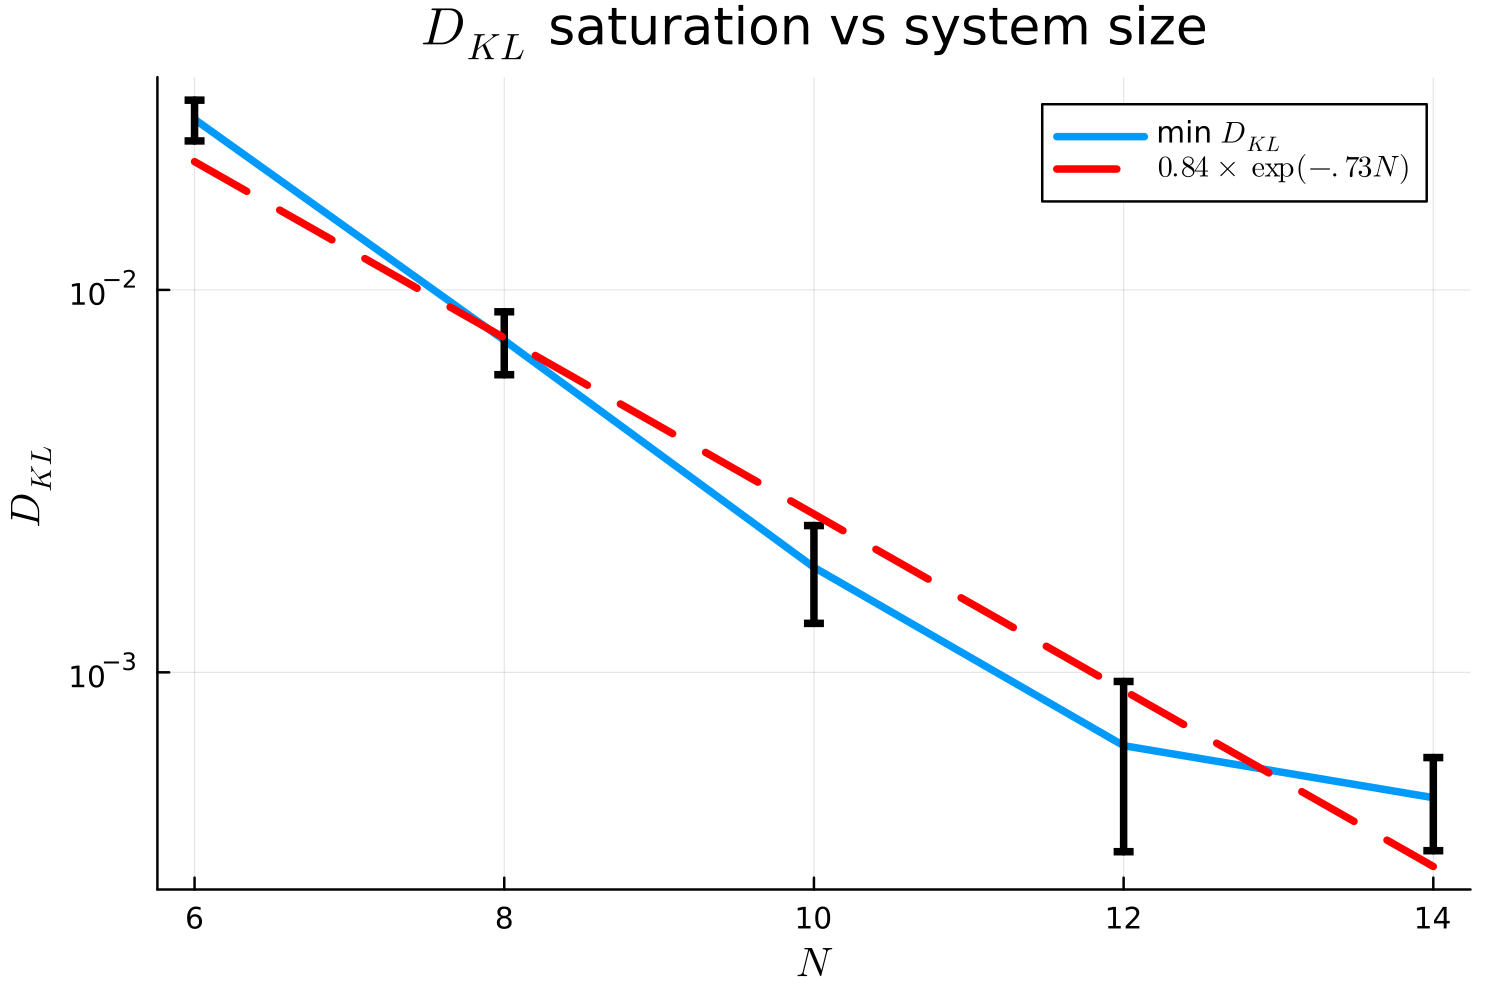

In [318]:
plot([6,8,10,12,14], ydata, yaxis = :log, linewidth = 3, label = L"min $D_{KL}$", yerr = errs, dpi = 250)

xax = LinRange(6, 14, 100)
plot!(xax, exp.(linear(xax, fit1.param)), label = L"0.84 \times \exp(-.73N)", color = :red, linewidth = 3, linestyle = :dash)
title!(L"$D_{KL}$ saturation vs system size")
xlabel!(L"N")
ylabel!(L"D_{KL}")

In [139]:
savefig("figs/system_size_DKL_saturation_14.png")

"/home/ben/Documents/AutonomaProject/figs/system_size_DKL_saturation_14.png"

In [319]:
fit1.param[1], exp(fit1.param[2])

(-0.5304895018819964, 0.5221064339813938)

In [320]:
fit2.param[1], exp(fit2.param[2])

(-1.269251116892049, 0.6950290967742211)

### Plotting

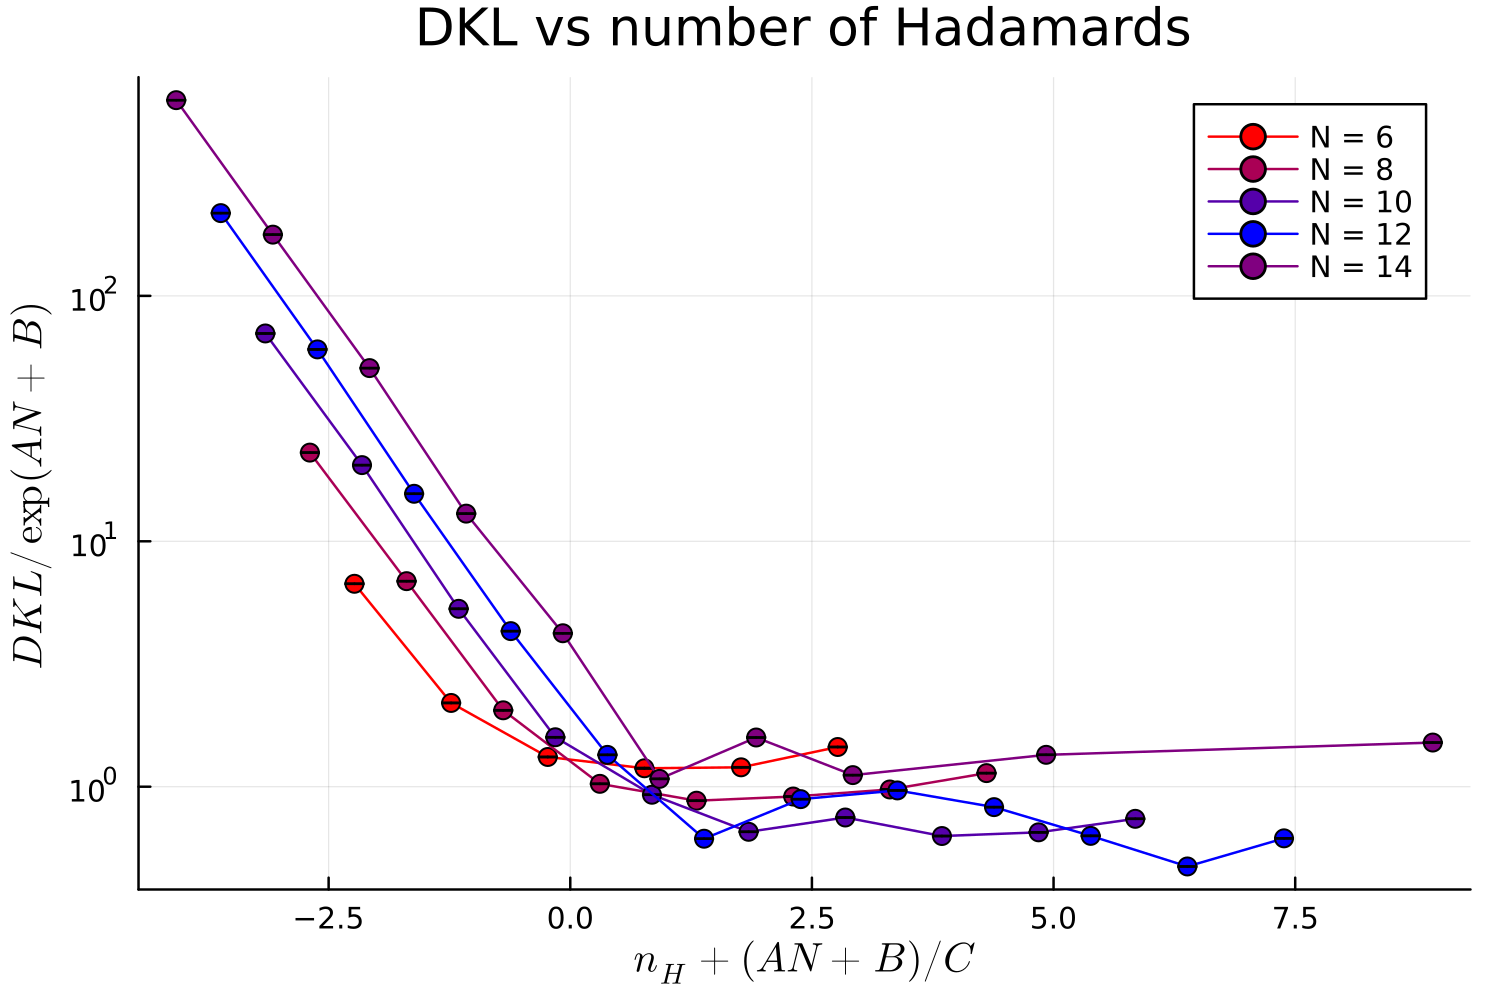

┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149


In [321]:
xax = LinRange(1, 4, 100)
p = plot(yaxis = :log, dpi = 250)
for (k,dist) in enumerate(KLDs)
	N = Ns[k]
	x = 1:N
	D = exp(first(linear([N], fit1.param)))
	b = -log(D)/fit2.param[1]
	plot!(x .+ log(D) .+ .6k, dist ./ D, label = "N = $(2*k+4)", marker = "x", color = sc[k], yerr = stds[k])
	#plot!(x, dist, label = "N = $(2*k+4)", marker = "x", color = sc[k], yerr = stds[k])
end

N = 14
x = ds_14
D = exp(first(linear([N], fit1.param)))
b = -log(D)/fit2.param[1]
plot!(x .+ log(D) .+ .6*5, KLDS_14 ./ D, label = "N = 14", marker = "x", color = :purple, yerr = stds_14)
#plot!(ds_14, KLDS_14, label = "N = 14", marker = "x", color = :purple, yerr = stds_14)

# save plot
title!("DKL vs number of Hadamards")
xlabel!(L"$n_H+(AN+B)/C$")
ylabel!(L"DKL/\exp(AN+B)")

display(p)

In [322]:
#savefig("figs/universal_scaling.png")

"/home/ben/Documents/AutonomaProject/figs/universal_scaling.png"

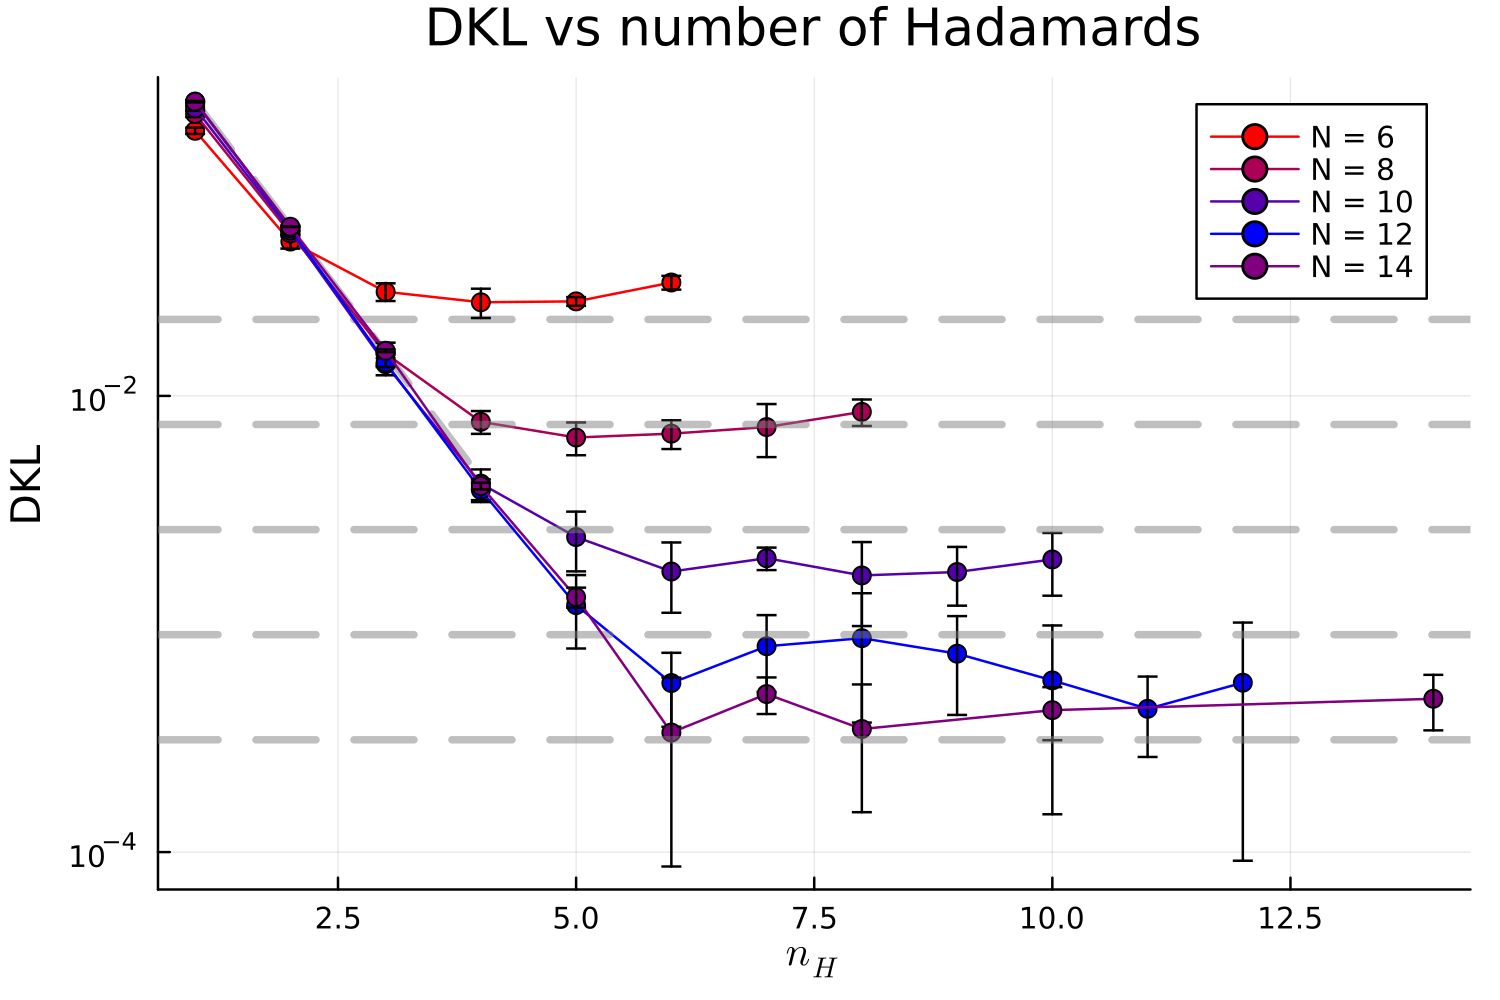

┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149


In [323]:
xax = LinRange(1, 4, 100)
p = plot(yaxis = :log, dpi = 250)
hline!(exp.(linear([Ns[1]], fit1.param)), color = :gray, alpha = .5, linestyle = :dash, linewidth = 3, label = "")
plot!(xax, exp.(linear(xax, fit2.param)), color = :gray, alpha = .5, linestyle = :dash, linewidth = 3, label = "")
for (k,dist) in enumerate(KLDs)
	plot!((1:Ns[k]), dist, label = "N = $(2*k+4)", marker = "x", color = sc[k], yerr = stds[k])
	if k != 1
		hline!(exp.(linear([Ns[k]], fit1.param)), color = :gray, alpha = .5, linestyle = :dash, linewidth = 3, label = "")
	end
end
plot!(ds_14, KLDS_14, label = "N = 14", marker = "x", color = :purple, yerr = stds_14)
hline!(exp.(linear([14], fit1.param)), color = :gray, alpha = .5, linestyle = :dash, linewidth = 3, label = "")

# save plot
title!("DKL vs number of Hadamards")
xlabel!(L"$n_H$")
ylabel!("DKL")

display(p)

In [95]:
savefig("figs/KLDS_14_first_trial.png")

"/home/ben/Documents/AutonomaProject/figs/KLDS_14_first_trial.png"

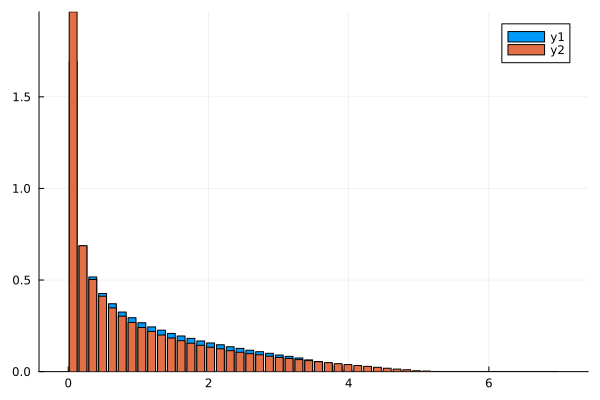

In [61]:
bar(axes(emp_bins), dat_rebin)
bar!(axes(emp_bins), mean(b))

In [62]:
sum(dat_rebin)

7.142857142857142

In [63]:
sum(mean(b))

7.142857142857142

In [65]:
sum(abs.(mean(b) .- dat_rebin).^2)

1.8277997467793727e-5

In [64]:
a,b,c = get_data(12, 8, num)

([0.0], [[1.6906738281249998, 0.6866455078124999, 0.5170549665178571, 0.4276820591517857, 0.36839076450892855, 0.3269740513392857, 0.29514857700892855, 0.26724679129464285, 0.2415248325892857, 0.22713797433035712  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.6911097935267856, 0.6892613002232142, 0.5144391741071428, 0.4281180245535714, 0.36926269531249994, 0.32523018973214285, 0.2938406808035714, 0.2659388950892857, 0.2450125558035714, 0.22452218191964285  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.6932896205357142, 0.6849016462053571, 0.5148751395089285, 0.42986188616071425, 0.36795479910714285, 0.32348632812499994, 0.2934047154017857, 0.2698625837053571, 0.2445765904017857, 0.2267020089285714  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.6924176897321428, 0.6870814732142857, 0.5144391741071428, 0.4281180245535714, 0.36839076450892855, 0.3247942243303571, 0.2938406808035714, 0.2668108258928571, 0.24719238281249997, 0.2262660435267857  …  0.0, 0.0, 

In [37]:
sum(mean(b)) * RANGE/NUM_BINS*num

1.0

In [139]:
fprime = - fit2.param[1]*(fit1.param[1]+ 0.37)

-0.21185284680336738

In [135]:
fit1.param[1]

-0.5009338701306416

In [30]:
savefig("figs/finite_size_scaling.png")

"/home/ben/Documents/AutonomaProject/figs/finite_size_scaling.png"

## Max diff

### Data organization

In [366]:
num = 30 #10 seems nice
RANGE = 7
NUM_BINS = 1000
emp_bins = bins((0,RANGE), RANGE/NUM_BINS*num);
dist_binned = discretize(semicircle_distribution, emp_bins);

### Plot max distance

In [164]:
maxs = []
stds = []
maxlocs = []
for n in Ns
	kld = Vector{Float64}()
	stdl = []
	maxsl = []
	hellinger = []
	maxlocsl = []
	for nH in 1:n
		exp_dists = get_data(n, nH, num)[2]
		dma = [max(abs.(dist_binned .- exp_dist)...) for exp_dist in exp_dists]
		push!(stdl, std(dma)/sqrt(bootstrap_samples))
		push!(maxsl, max(abs.(dist_binned .- sum(exp_dists)/length(exp_dists))...))
		push!(maxlocsl, (argmax(abs.(dist_binned .- sum(exp_dists)/length(exp_dists)))-1)*RANGE/NUM_BINS)
	end
	push!(maxs, maxsl)
	push!(stds, stdl)
	push!(maxlocs, maxlocsl)
end

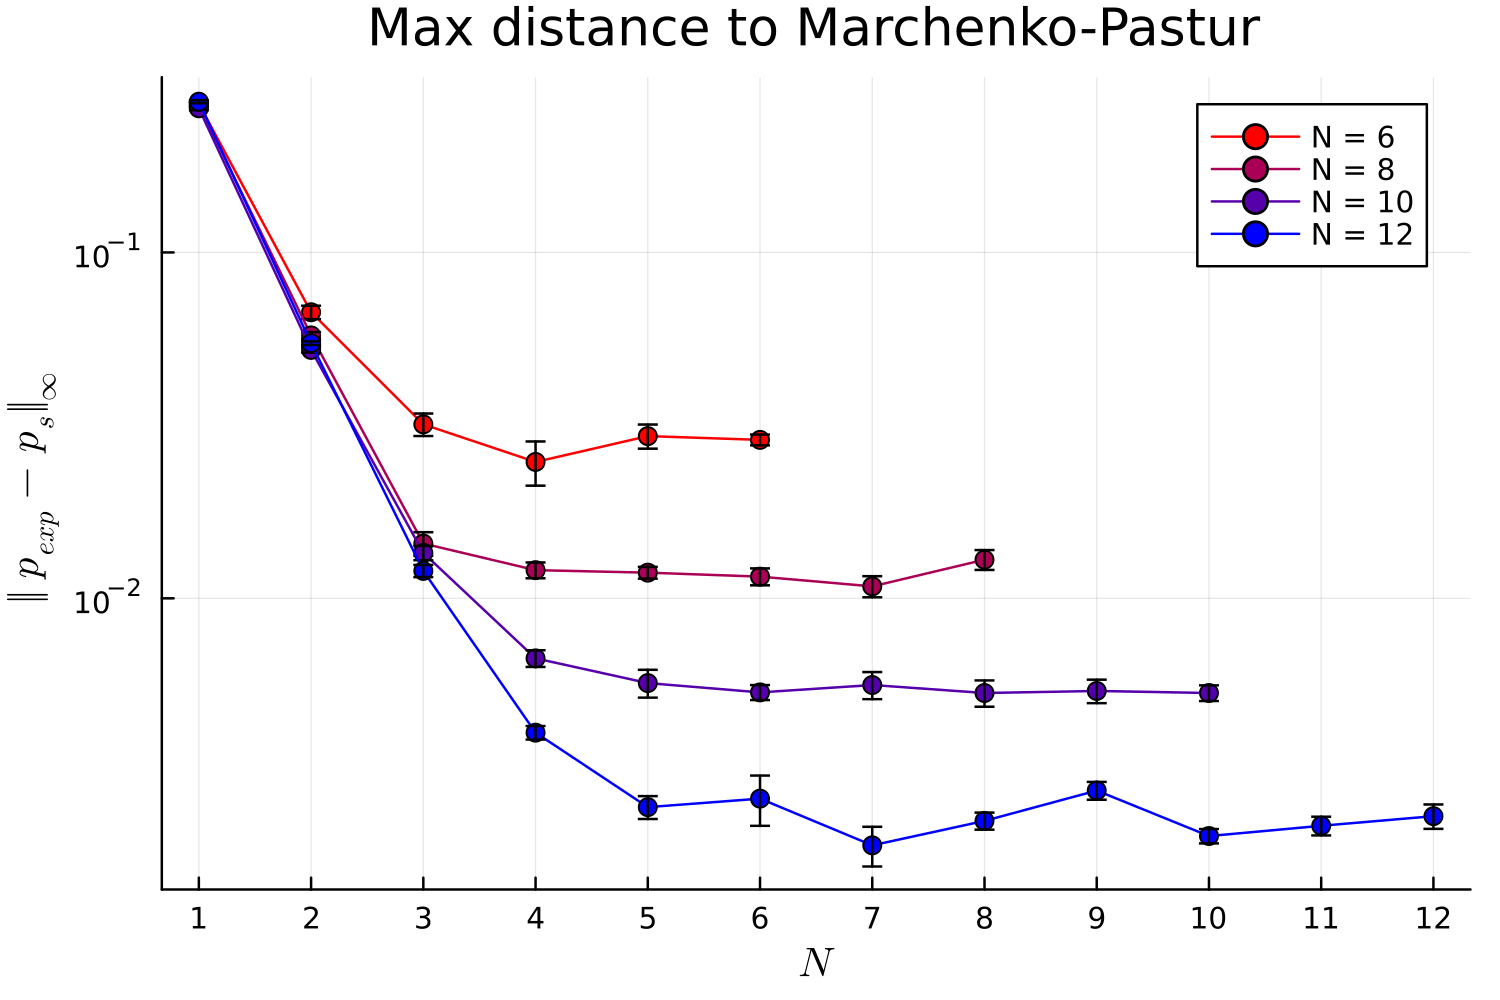

┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149


In [165]:
p = plot(yaxis = :log, dpi = 250)
xax = LinRange(1, 4, 100)
for (k,dist) in enumerate(maxs)
	plot!((1:Ns[k]), dist, label = "N = $(2*k+4)", marker = "x", color = sc[k], yerr = stds[k])
end

title!("Max distance to Marchenko-Pastur")
xlabel!(L"N")
ylabel!(L"\Vert p_{exp} - p_{s} \Vert_{\infty}")
xticks!(1:12)

display(p)

In [369]:
savefig("figs/max_dist_to_semicircle.png")

"/home/ben/Documents/AutonomaProject/figs/max_dist_to_semicircle.png"

### Kernel prob. vs system size

In [31]:
num_zeros = []
for n in Ns
	num_zeros_l = []
	for nH in 1:n
		nor = sum(sum(get_data(n, nH, 1; rebin = false)[2]))
		z = first(get_data(n, nH, 1, rebin = false)[1])
        push!(num_zeros_l, log(z) - log(nor))
	end
	push!(num_zeros, num_zeros_l)
end

In [32]:
p0 = fit2.param
fit3 = curve_fit(linear, Ns, getindex.(num_zeros, 1), p0)
exp(fit3.param[1]), fit3.param[2]

(0.5190443030070696, -1.2637624787647999)

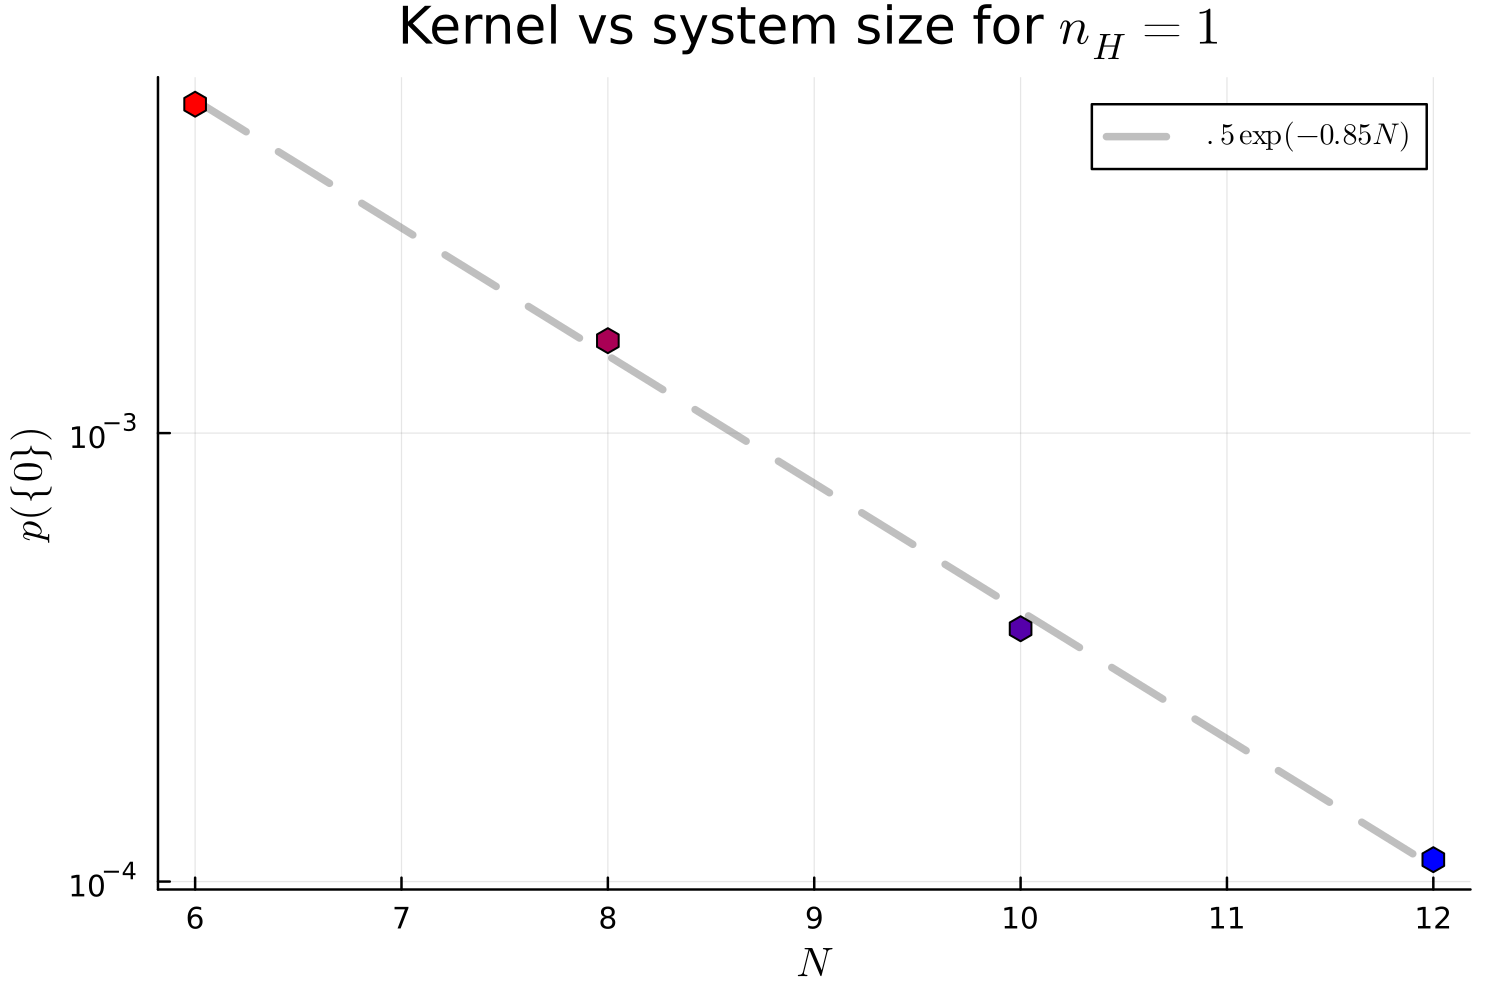

In [33]:
xax = LinRange(6, 12, 100)
p = plot(xax, exp.(linear(xax, fit3.param)), yaxis = :log, dpi = 250, linewidth = 3, linestyle = :dash, alpha = 0.5, color = :Gray ,label = L".5 \exp(-0.85 N)")
for i in 1:4
    scatter!([Ns[i]], [exp(num_zeros[i][1])], markershape = :hexagon, markersize = 5, color = sc[i], label = "")
end

title!(L"Kernel vs system size for $n_H = 1$")
xlabel!(L"N")
ylabel!(L"p(\{0\})")

display(p)

In [34]:
savefig("figs/kernel_vs_system_size")

"/home/ben/Documents/AutonomaProject/figs/kernel_vs_system_size.png"

### Tail probability

In [167]:
tail_probability = []
stds = []
for n in Ns
	stdl = []
	tail_prob_l = []
	for nH in 1:n
		dat = get_data(n, nH, 1)[2]
		tail = get_data(n, nH, 1, rebin = false)
        cutoff = Int(ceil(4 / (RANGE/NUM_BINS)))
		tail_probs = [sum(d[cutoff:end]) for d in dat] * (RANGE/NUM_BINS)
		push!(stdl, std(tail_probs)/sqrt(bootstrap_samples))
        push!(tail_prob_l, mean(tail_probs))
	end
	push!(tail_probability, tail_prob_l)
	push!(stds, stdl)
end

stdl = []
tail_prob_l = []
for nH in [1,2,3,4,5,6,7,8,10,14]
	dat = get_data_14(nH)[2]
	tail = get_data_14(n, nH, 1, rebin = false)
	cutoff = Int(ceil(4 / (RANGE/NUM_BINS)))
	tail_probs = [sum(d[cutoff:end]) for d in dat] * (RANGE/NUM_BINS)
	push!(stdl, std(tail_probs)/sqrt(bootstrap_samples))
	push!(tail_prob_l, mean(tail_probs))
end

In [170]:
get_data_14(8)

(5.92164985901256e-6, 6.605178747676563e-7)

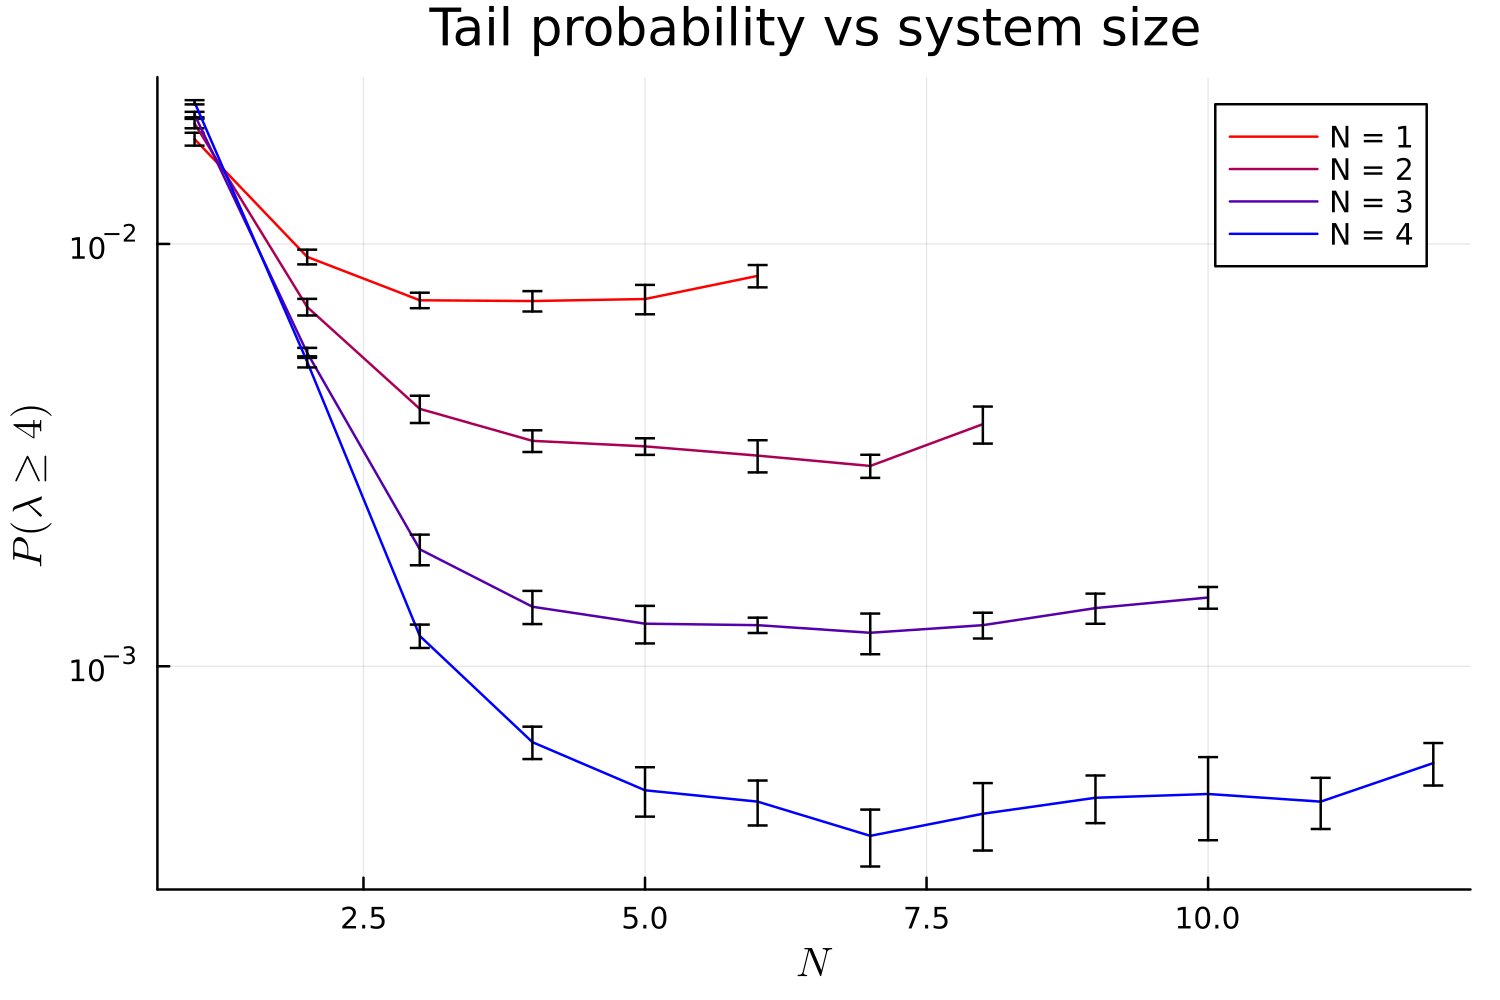

In [168]:
p = plot(dpi = 250, yaxis = :log)
for i in 1:4
    plot!(1:Ns[i], tail_probability[i], color = sc[i], yerr = 2 .* stds[i], label = "N = $(i)")
end

title!("Tail probability vs system size")
xlabel!(L"N")
ylabel!(L"P(\lambda \geq 4)")

display(p)

In [279]:
savefig("figs/tail_probability.png")

"/home/ben/Documents/AutonomaProject/figs/tail_probability.png"

### Illustrative pictures

In [39]:
num = 20 #10 seems nice
RANGE = 100
NUM_BINS = 20000

emp_bins = bins((0,RANGE), RANGE/NUM_BINS*num);
dist_binned = discretize(semicircle_distribution, emp_bins);

In [40]:
plot(axes(emp_bins), log.(dist_binned), linewidth = 3, dpi = 250, label = "")
dat = mean(get_data(12, 1, num)[2])
plot!(axes(emp_bins), log.(dat),  linewidth = 2, label = "")
dat = mean(get_data(12, 6, num)[2])
plot!(axes(emp_bins), log.(dat),  linewidth = 2, label = "")
xlims!(0, 5.8)
title!("Tail convergence")
xlabel!(L"\lambda")
ylabel!(L"\log p(\lambda)")

In [379]:
savefig("figs/MP_tail_convergence.png")

"/home/ben/Documents/AutonomaProject/figs/MP_tail_convergence.png"

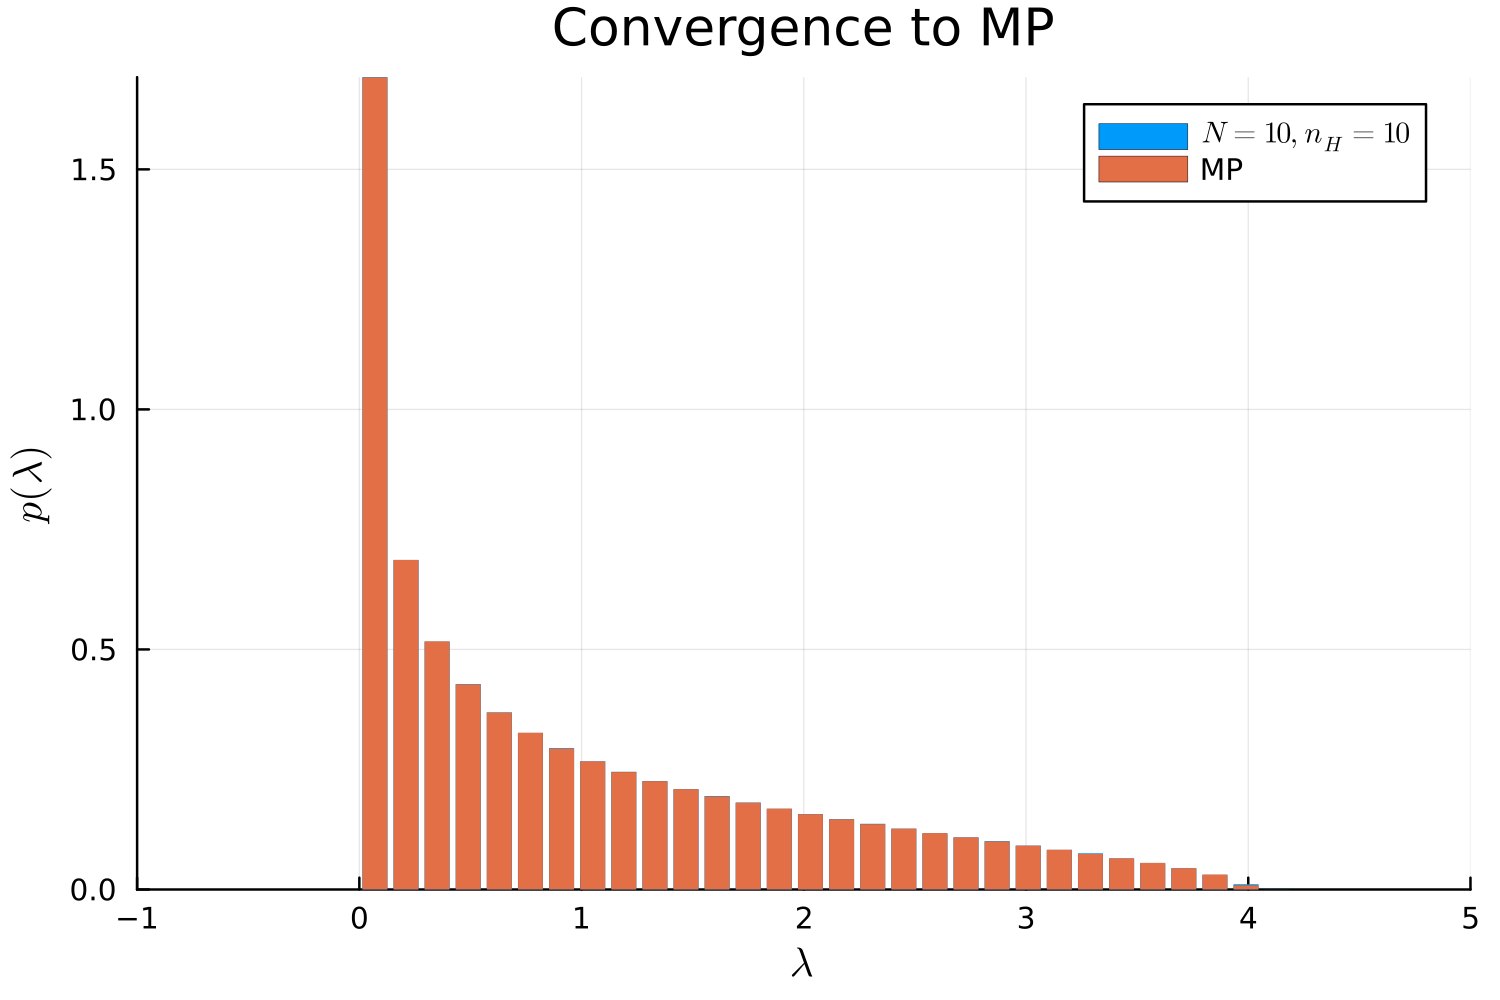

In [25]:
#dat = mean(get_data(6, 3, num)[2])
#bar!(axes(emp_bins), dat, label = L"N = 6, n_H = 1", linewidth = 0)
num = 20
RANGE = 7.0
NUM_BINS = 1000
emp_bins = bins((0,RANGE), RANGE/NUM_BINS*num);
dist_binned = discretize(semicircle_distribution, emp_bins);

dat = mean(get_data(12, 8, num)[2])
bar(axes(emp_bins), dat, label = L"N = 10, n_H = 10", linewidth = 0)
bar!(axes(emp_bins), dist_binned, label = "MP", linewidth = 0,  dpi = 250)
title!("Convergence to MP")
xlabel!(L"\lambda")
ylabel!(L"p(\lambda)")
xlims!(-1, 5)

In [335]:
savefig("figs/MP_convergence_at_zero.png")

"/home/ben/Documents/AutonomaProject/figs/MP_convergence_at_zero.png"

## Average ratios

In [ ]:
rats = []
stds = []
for n in Ns
	rat = []
	stdl = []
	for nH in 1:n
		dat = get_data(n, nH, num)[3]
		push!(rat, mean(dat))
		push!(stdl, std(dat)/sqrt(bootstrap_samples))
	end
	push!(rats, rat)
	push!(stds, stdl)
end

p = plot(dpi = 250)
for (k,rat) in enumerate(rats)
	plot!((1:Ns[k]), rat, label = "N = $(2*k+4)", marker = "x", color = sc[k], yerr = stds[k])
end
display(p)

## Scaling law

In [41]:
a = []
t = []
dat = []
for (i,N) in enumerate(Ns)
	for nH in 1:2
		push!(a, N)
		push!(t, nH)
		push!(dat, KLDs[i][nH])
	end
end

x = [a t]
p0 = [2, 3, 0.09]

fit = curve_fit(model, x, dat, p0)
fit.param

p = plot(yaxis = :log, dpi = 250)
xax = LinRange(1, 3, 100)
for (k,dist) in enumerate(KLDs)
	plot!((1:Ns[k]), dist, label = "N = $(2*k+4)", marker = "x", color = sc[k])
	x = [[Ns[k] for i in 1:length(xax)] xax]
	plot!(xax, model(x, p0))
end
display(p)

UndefVarError: UndefVarError: `model` not defined

## KLD vs system size for Z operator

### Organize data

In [158]:
function get_data(N, nH, num; rebin = true)
	f = open("data/Z_N$(N)_nH$(nH).csv", read = true)
	l = read(f, String)
	close(f)
	dat = split(l, ",")
	dists = [parse.(Float64, split(d, "\n")[2:end-1]) for d in dat[2:end-1]]
	overflow = parse.(Float64, split(dat[end], "\n")[2:end-1])
	if rebin
		dat_rebin = [[float(sum([d[i*num+j] for j in 1:num])) for i in 0:length(d)÷num-1] for d in dists]
		dat_rebin = [d ./ ((sum(d)+length(overflow)/bootstrap_samples)*RANGE/NUM_BINS*num) for d in dat_rebin]
		#dat_rebin = [d ./ ((sum(d))*RANGE/NUM_BINS*num) for d in dat_rebin]
		parse.(Float64, split(dat[1], "\n")[2:end-1]), dat_rebin, overflow
	else
		parse.(Float64, split(dat[1], "\n")[2:end-1]), dists, overflow
	end
end

get_data (generic function with 1 method)

In [168]:
#organize data
num = 21 #10 seems nice
RANGE = 7.0
NUM_BINS = 1000
emp_bins = bins((0,RANGE), RANGE/NUM_BINS*num);
dist_binned = discretize(semicircle_distribution, emp_bins);

Ns = [6,8,10,12]
#bootstrap_samples = 3
#samples = [2^9, 2^7, 2^5, 8]
bootstrap_samples = 3
samples = [2^9, 2^7, 2^5, 8]

sc = range(colorant"red", colorant"blue", 4)

KLDs = []
stds = []
for n in Ns
	stdl = []
	kld = []
	for nH in 1:n
		exp_dists = get_data(n, nH, num)[2]
		avg_dist = sum(exp_dists)/length(exp_dists)
		kl = [KLD(exp_dist, semicircle_distribution, emp_bins) for exp_dist in exp_dists]
		push!(stdl, std(kl))
		push!(kld, KLD(avg_dist, semicircle_distribution, emp_bins))
	end
	push!(KLDs, kld)
	push!(stds, stdl)
end

### Size scaling analysis

In [169]:
@. linear(x,p) = p[1]*x+p[2] #better to log and then fit to a line!

#Fit initial line
p0 = [0.05, .5]
fit2 = curve_fit(linear, 2:10, log.(KLDs[end][2:10]), p0)

#fit size-dependent saturation
ydata = [mean(KLDs[k][end-k:end]) for k in 1:length(KLDs)]
errs = [2*mean(stds[k][end-k:end])/sqrt(k+1) for k in 1:length(KLDs)]

p0 = [1, 0.5]
fit1 = curve_fit(linear, Ns[1:end], log.(ydata[1:end]), p0);

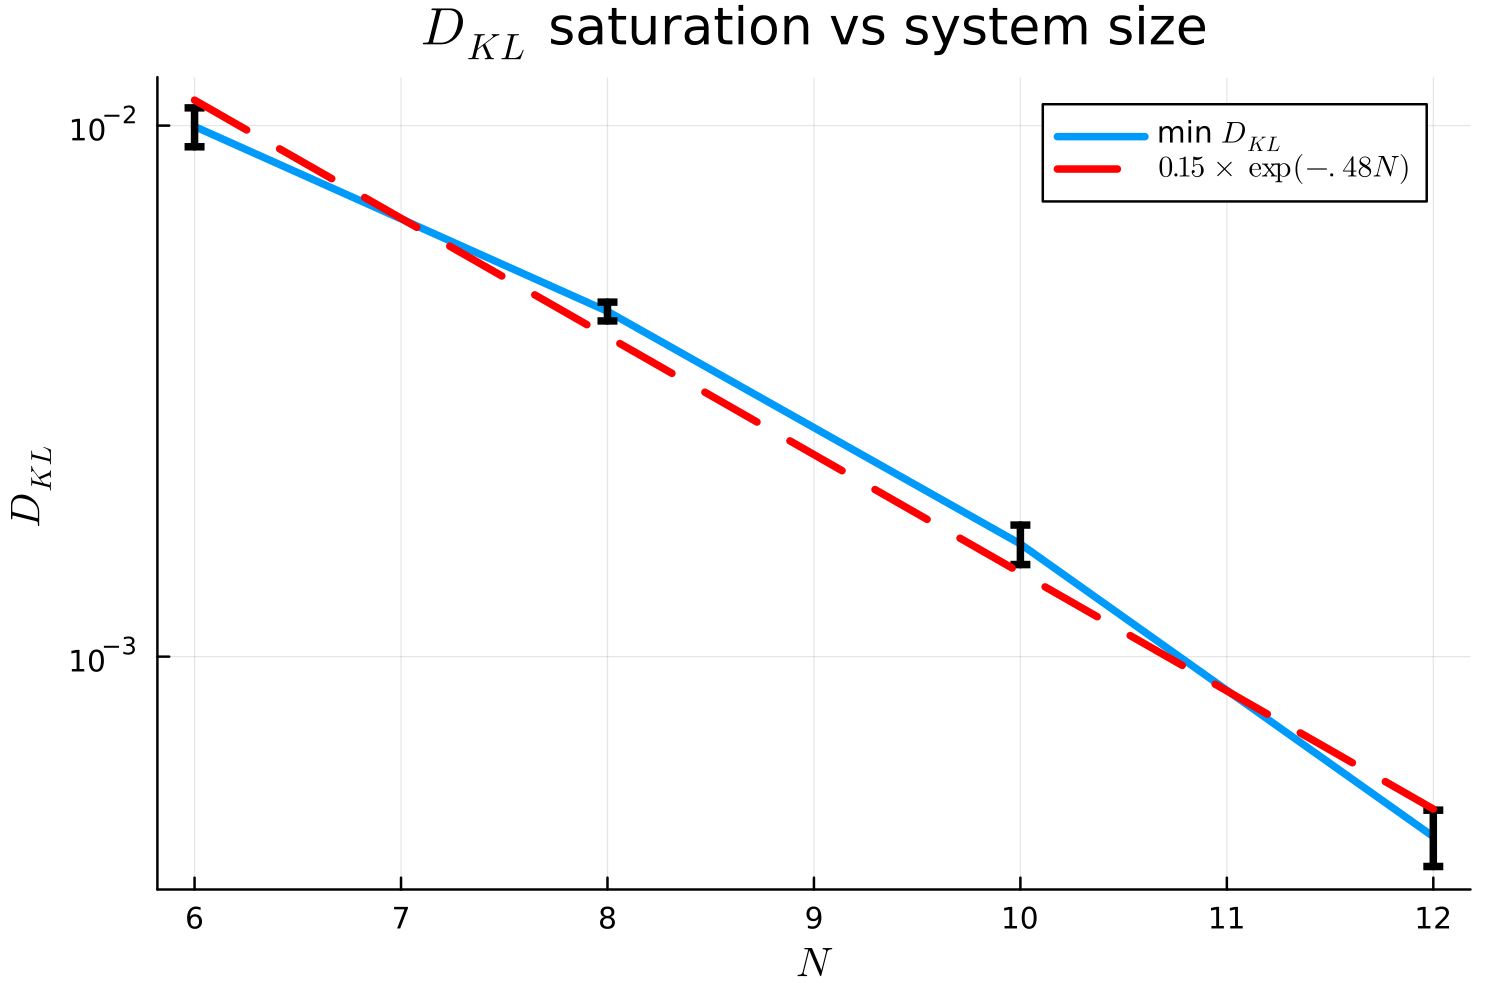

In [170]:
plot(Ns, ydata, yaxis = :log, linewidth = 3, label = L"min $D_{KL}$", yerr = errs, dpi = 250)

xax = LinRange(6, 12, 100)
plot!(xax, exp.(linear(xax, fit1.param)), label = L"0.15 \times \exp(-.48N)", color = :red, linewidth = 3, linestyle = :dash)
title!(L"$D_{KL}$ saturation vs system size")
xlabel!(L"N")
ylabel!(L"D_{KL}")

In [91]:
savefig("figs/system_size_DKL_saturation.png")

"/home/ben/Documents/AutonomaProject/figs/system_size_DKL_saturation.png"

In [171]:
fit1.param[1], exp(fit1.param[2])

(-0.5122901725014258, 0.24142997089823293)

In [172]:
fit2.param[1], exp(fit2.param[2])

(-0.743261019837948, 0.4677476947875027)

### Plotting

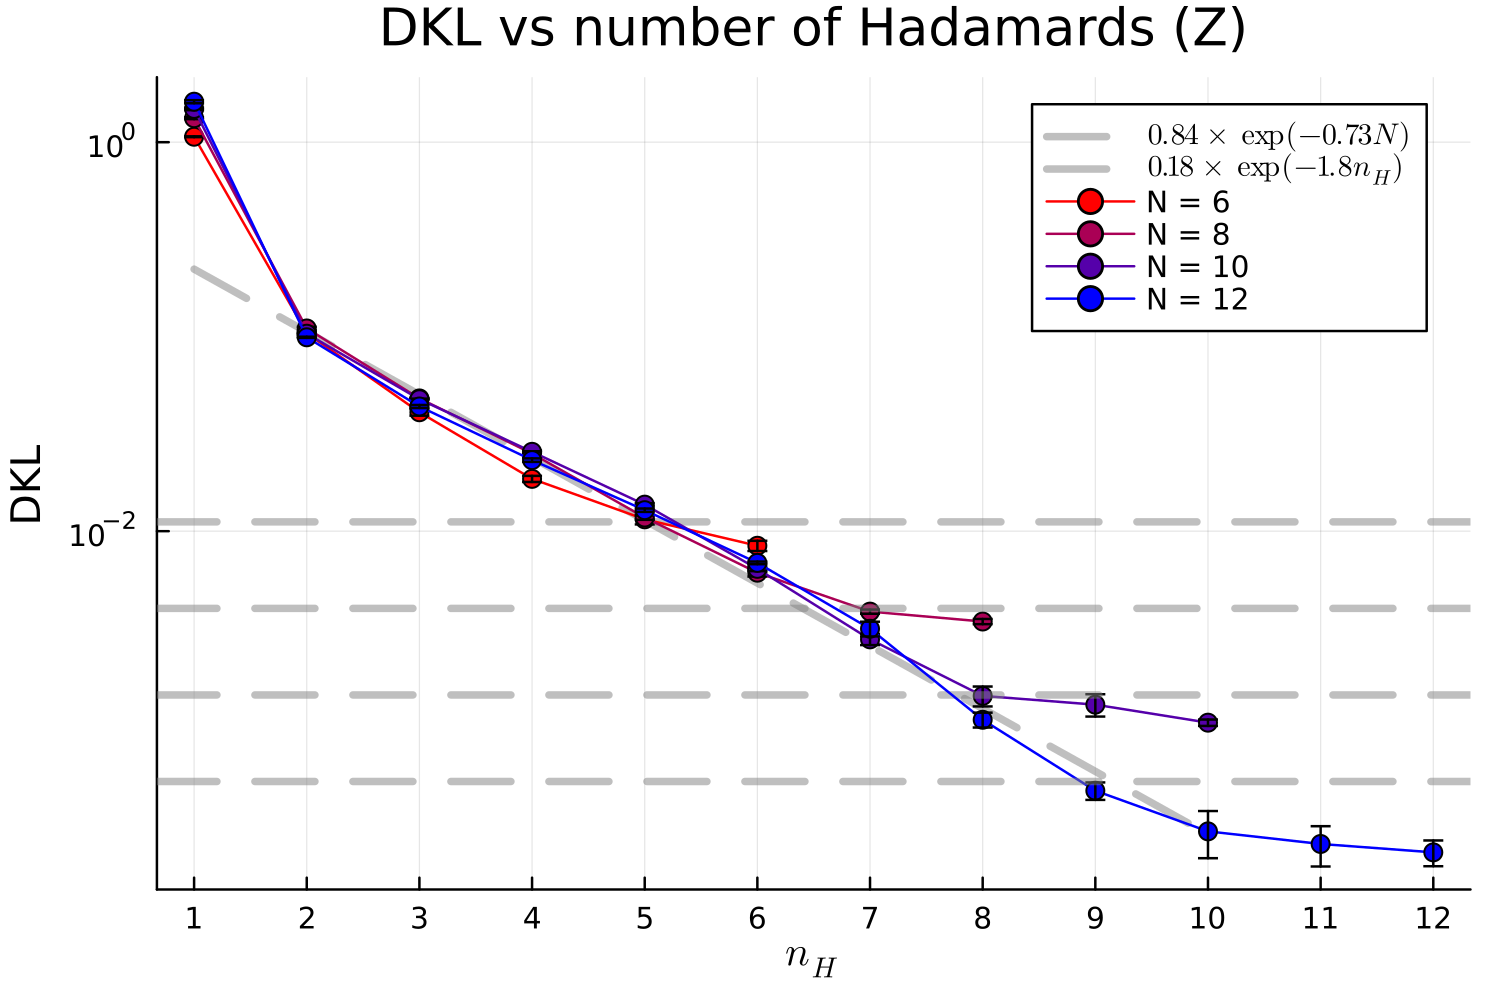

┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149


In [173]:
xax = LinRange(1, 10, 100)
p = plot(yaxis = :log, dpi = 250)
hline!(exp.(linear([Ns[1]], fit1.param)), color = :gray, alpha = .5, linestyle = :dash, linewidth = 3, label = L"0.84 \times \exp(-0.73 N)")
plot!(xax, exp.(linear(xax, fit2.param)), color = :gray, alpha = .5, linestyle = :dash, linewidth = 3, label = L"0.18 \times \exp(-1.8 n_H)")
for (k,dist) in enumerate(KLDs)
	plot!((1:Ns[k]), dist, label = "N = $(2*k+4)", marker = "x", color = sc[k], yerr = stds[k])
	if k != 1
		hline!(exp.(linear([Ns[k]], fit1.param)), color = :gray, alpha = .5, linestyle = :dash, linewidth = 3, label = "")
	end
end

# save plot
title!("DKL vs number of Hadamards (Z)")
xlabel!(L"$n_H$")
ylabel!("DKL")
xticks!(0:12)

display(p)

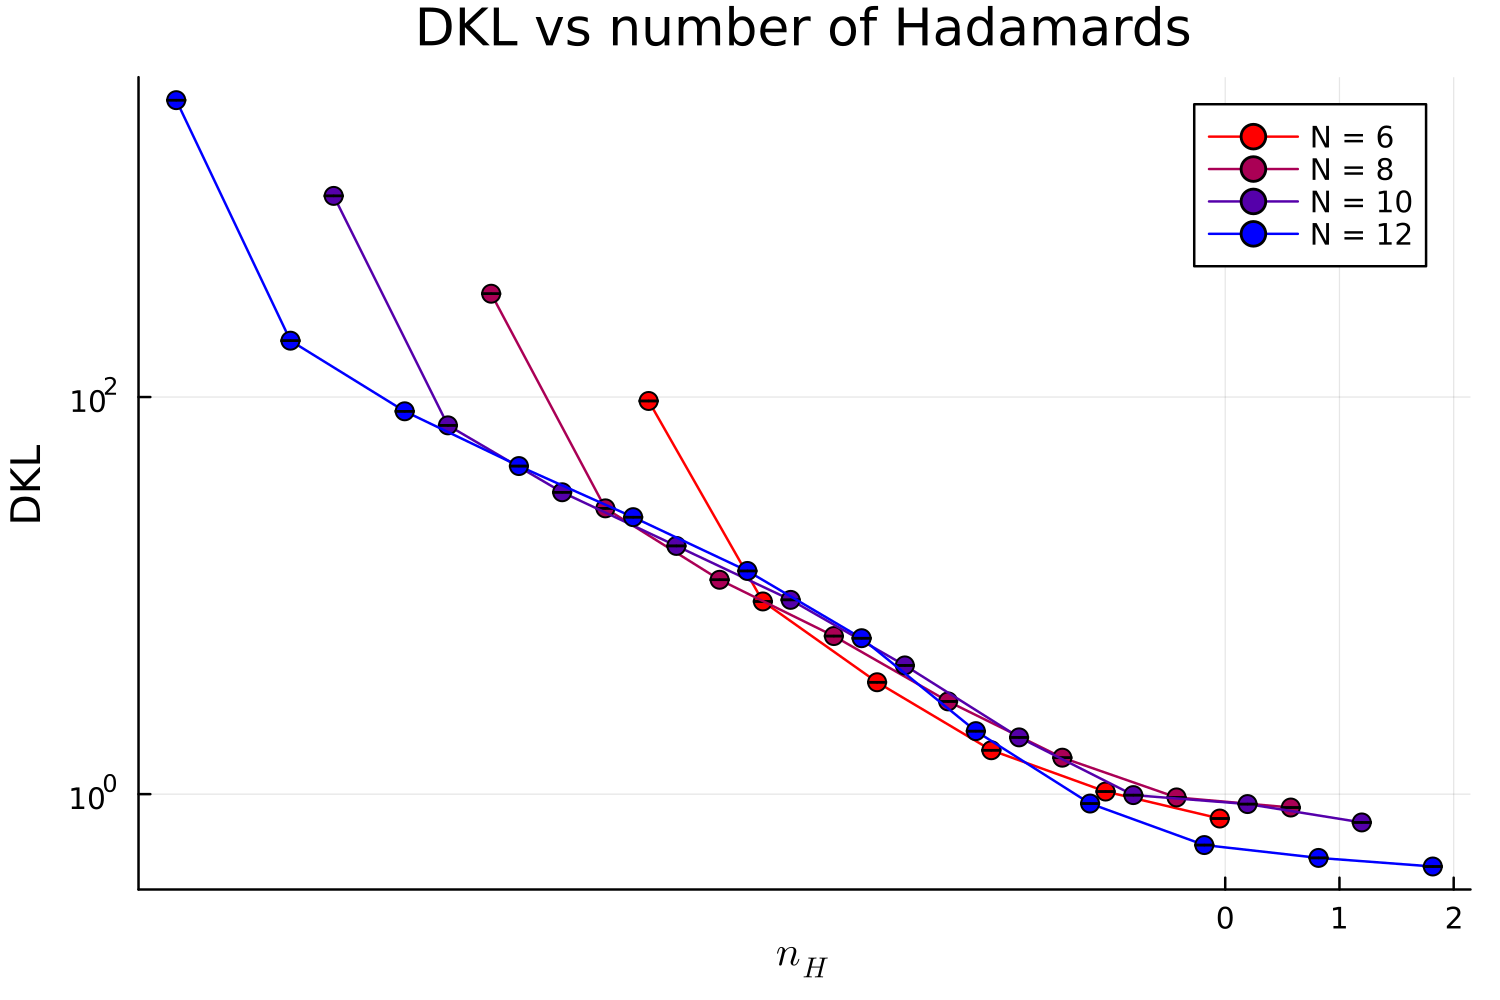

┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149
┌ Warning: Skipped marker arg x.
└ @ Plots /home/ben/.julia/packages/Plots/ju9dp/src/args.jl:1149


In [174]:
p = plot(yaxis = :log, dpi = 250)
for (k,dist) in enumerate(KLDs)
	N = Ns[k]
	x = 1:N
	D = exp(first(linear([N], fit1.param)))
	b = -log(D)/fit2.param[1]
	plot!(x .+ b, dist ./ D, label = "N = $(2*k+4)", marker = "x", color = sc[k], yerr = stds[k])
end

# save plot
title!("DKL vs number of Hadamards")
xlabel!(L"$n_H$")
ylabel!("DKL")
xticks!(0:12)

display(p)

In [71]:
savefig("figs/finite_size_scaling_Z.png")

"/home/ben/Documents/AutonomaProject/figs/finite_size_scaling_Z.png"

In [1]:
num = 20
RANGE = 7.0
NUM_BINS = 1000
emp_bins = bins((0,RANGE), RANGE/NUM_BINS*num);
dist_binned = discretize(semicircle_distribution, emp_bins);

dat = get_data(12, 4, num)[2][2]
bar(axes(emp_bins), dat, label = L"N = 12, n_H = 11", linewidth = 0)
bar!(axes(emp_bins), dist_binned, label = "MP", linewidth = 0,  dpi = 250)
title!("Convergence to MP")
xlabel!(L"\lambda")
ylabel!(L"p(\lambda)")
xlims!(-1, 20)

UndefVarError: UndefVarError: `bins` not defined